# Homework 2: California Housing Prices

## Setup

In [23]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Download and load dataset
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
df = pd.read_csv('housing.csv')

--2023-09-26 15:49:57--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8001::154, 2606:50c0:8002::154, 2606:50c0:8003::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8001::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1423529 (1.4M) [text/plain]
Saving to: 'housing.csv.3'

     0K .......... .......... .......... .......... ..........  3% 14.7M 0s
    50K .......... .......... .......... .......... ..........  7% 10.5M 0s
   100K .......... .......... .......... .......... .......... 10% 17.9M 0s
   150K .......... .......... .......... .......... .......... 14% 3.38M 0s
   200K .......... .......... .......... .......... .......... 17% 8.41M 0s
   250K .......... .......... .......... .......... .......... 21% 73.8M 0s
   300K .......... .......... .......... .......... .......... 25% 22.4M 0s
   350K ......

In [24]:
# Check data
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [25]:
df['median_house_value'].describe()

count     20640.000000
mean     206855.816909
std      115395.615874
min       14999.000000
25%      119600.000000
50%      179700.000000
75%      264725.000000
max      500001.000000
Name: median_house_value, dtype: float64

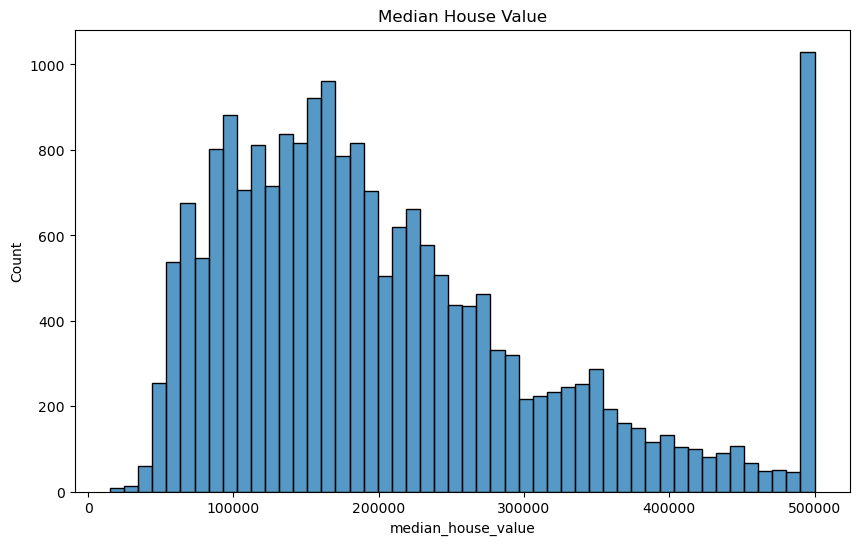

In [26]:
# Plot histogram of median house value
plt.figure(figsize=(10, 6))
sns.histplot(df['median_house_value'], bins=50)
plt.title('Median House Value')
plt.show()
# It seems that the median house value is capped at 500,000
# It does not have a long tail

In [27]:
# Preparing the dataset
# Keep only records with ocean_proximity is either '<1H OCEAN' or 'INLAND'
df = df[df['ocean_proximity'].isin(['<1H OCEAN', 'INLAND'])]
# Drop the ocean_proximity column
df = df.drop('ocean_proximity', axis=1)

## Question 1

There's one feature with missing values. What is it?

- total_rooms
- total_bedrooms
- population
- households

**ANSWER: total_bedrooms**

In [28]:
df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        157
population              0
households              0
median_income           0
median_house_value      0
dtype: int64

## Question 2

What's the median (50% percentile) for variable 'population'?

- 995
- 1095
- 1195
- 1295

**ANSWER: 1195**

In [29]:
df.population.describe()

count    15687.000000
mean      1466.317205
std       1180.389908
min          3.000000
25%        802.000000
50%       1195.000000
75%       1777.000000
max      35682.000000
Name: population, dtype: float64

In [30]:
# Apply log transformation and drop target from dataset
y = np.log1p(df['median_house_value'].values)
df = df.drop('median_house_value', axis=1)

# Split dataset into train, validation and test sets (60%, 20%, 20%)
np.random.seed(42)
n = len(df)
n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test
# Shuffle the dataset
idx = np.arange(n)
np.random.shuffle(idx)
# Split the dataset
df_train = df.iloc[idx[:n_train]].copy().reset_index(drop=True)
df_val = df.iloc[idx[n_train:n_train+n_val]].copy().reset_index(drop=True)
df_test = df.iloc[idx[n_train+n_val:]].copy().reset_index(drop=True)

# Get target for each set
y_train = y[idx[:n_train]]
y_val = y[idx[n_train:n_train+n_val]]
y_test = y[idx[n_train+n_val:]]

## Question 3

- We need to deal with missing values for the column from Q1.
- We have two options: fill it with 0 or with the mean of this variable.
- Try both options. For each, train a linear regression model without - regularization using the code from the lessons.
- For computing the mean, use the training only!
- Use the validation dataset to evaluate the models and compare the RMSE of each option.
- Round the RMSE scores to 2 decimal digits using round(score, 2)

Which option gives better RMSE?

- With 0
- With mean
- Both are equally good


**ANSWER: EQUALLY GOOD**

In [32]:
# Define functions to train and predict
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

def prepare_X(df, null_treatment = 'zero'):
    df_num = df.copy()
    if null_treatment == 'zero':
        df_num = df_num.fillna(0)
    elif null_treatment == 'mean':
        df_num = df_num.fillna(df_num.mean())
    else:
        raise ValueError('null_treatment can only be zero or mean')
    
    return df_num.values

def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [34]:
# Zero imputation
X_train = prepare_X(df_train)
w_0, w = train_linear_regression(X_train, y_train)

y_pred = w_0 + X_train.dot(w)
print('train - zero:', round(rmse(y_train, y_pred), 2))

X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)
print('validation - zero:', round(rmse(y_val, y_pred), 2))

# Mean imputation
X_train = prepare_X(df_train, 'mean')
w_0, w = train_linear_regression(X_train, y_train)

y_pred = w_0 + X_train.dot(w)
print('train - mean:', round(rmse(y_train, y_pred), 2))

X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)
print('validation - mean:', round(rmse(y_val, y_pred), 2))

train - zero: 0.34
validation - zero: 0.34
train - mean: 0.34
validation - mean: 0.34


## Question 4

- Now let's train a regularized linear regression.
- For this question, fill the NAs with 0.
- Try different values of r from this list: [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10].
- Use RMSE to evaluate the model on the validation dataset.
- Round the RMSE scores to 2 decimal digits.

Which r gives the best RMSE?

- 0
- 0.000001
- 0.001
- 0.0001

**ANSWER: 0**

In [35]:
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [36]:
X_train = prepare_X(df_train)
X_val = prepare_X(df_val)

for r in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    w_0, w = train_linear_regression_reg(X_train, y_train, r=r)
    y_pred = w_0 + X_val.dot(w)
    print('%6s' %r, round(rmse(y_val, y_pred), 2))

     0 0.34
 1e-06 0.34
0.0001 0.34
 0.001 0.34
  0.01 0.34
   0.1 0.34
     1 0.34
     5 0.35
    10 0.35


## Question 5

- We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
- Try different seed values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9].
- For each seed, do the train/validation/test split with 60%/20%/20% distribution.
- Fill the missing values with 0 and train a model without regularization.
- For each seed, evaluate the model on the validation dataset and collect the RMSE scores.
- What's the standard deviation of all the scores? To compute the standard deviation, use np.std.
- Round the result to 3 decimal digits (round(std, 3))

What's the value of std?

- 0.5
- 0.05
- 0.005
- 0.0005

**ANSWER: 0.005**

In [50]:
def get_rmse_vector(y, X, seed,
                    split_vector = [.6, .2, .2],
                    null_treatment = 'zero',
                    reg = False,
                    r = 0.0):
    # Split dataset into train, validation and test sets (60%, 20%, 20%)
    np.random.seed(seed)
    n = len(y)
    n_val = int(n * split_vector[1])
    n_test = int(n * split_vector[2])
    n_train = n - n_val - n_test
    
    # Shuffle the dataset
    idx = np.arange(n)
    np.random.shuffle(idx)
    
    # Split the dataset
    X_train = X.iloc[idx[:n_train]].copy().reset_index(drop=True)
    X_val = X.iloc[idx[n_train:n_train+n_val]].copy().reset_index(drop=True)
    X_test = X.iloc[idx[n_train+n_val:]].copy().reset_index(drop=True)

    # Get target for each set
    y_train = y[idx[:n_train]]
    y_val = y[idx[n_train:n_train+n_val]]
    y_test = y[idx[n_train+n_val:]]
    
    # Get weights
    X_train = prepare_X(X_train, null_treatment)
    if reg:
        w_0, w = train_linear_regression_reg(X_train, y_train, r=r)
    else:
        w_0, w = train_linear_regression(X_train, y_train)
    
    # Get predictions
    # Training
    y_pred = w_0 + X_train.dot(w)
    rmse_train = rmse(y_train, y_pred)
    # Validation
    X_val = prepare_X(X_val, null_treatment)
    y_pred = w_0 + X_val.dot(w)
    rmse_val = rmse(y_val, y_pred)
    
    # Get test rmse with combined train and validation sets
    X_full = np.vstack((X_train, X_val))
    y_full = np.concatenate([y_train, y_val])
    # Get weights
    if reg:
        w_0, w = train_linear_regression_reg(X_full, y_full, r=r)
    else:
        w_0, w = train_linear_regression(X_full, y_full)
    # Get predictions and rmse
    y_pred = w_0 + X_full.dot(w)    
    rmse_test = rmse(y_full, y_pred)

    return rmse_train, rmse_val, rmse_test

In [51]:
# Try different seeds
rmse_vals = []
for seed in np.arange(10):
    _, rmse_val, _ = get_rmse_vector(y, df, seed)
    rmse_vals.append(rmse_val)

In [52]:
round(np.std(rmse_vals), 3)

0.005

## Question 6

- Split the dataset like previously, use seed 9.
- Combine train and validation datasets.
- Fill the missing values with 0 and train a model with r=0.001.

What's the RMSE on the test dataset?

- 0.13
- 0.23
- 0.33
- 0.43

**ANSWER: 0.33**

In [57]:
_, _, rmse_test = get_rmse_vector(y, df, 9, reg=True, r=0.001)
rmse_test

0.33931756759095905